## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [2]:
BASE_DIR = 'UTKFace-new/UTKFace/'

In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,UTKFace-new/UTKFace/100_0_0_20170112213500903....,100,0
1,UTKFace-new/UTKFace/100_0_0_20170112215240346....,100,0
2,UTKFace-new/UTKFace/100_1_0_20170110183726390....,100,1
3,UTKFace-new/UTKFace/100_1_0_20170112213001988....,100,1
4,UTKFace-new/UTKFace/100_1_0_20170112213303693....,100,1


In [5]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

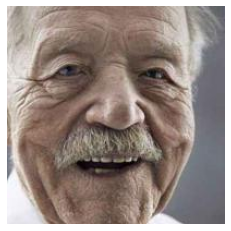

In [6]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

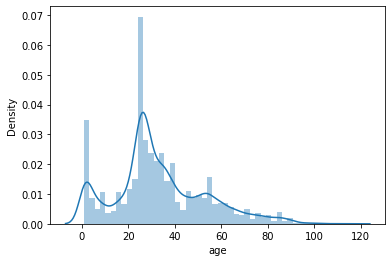

In [7]:
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

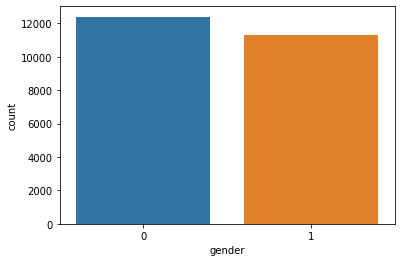

In [8]:
sns.countplot(df['gender'])

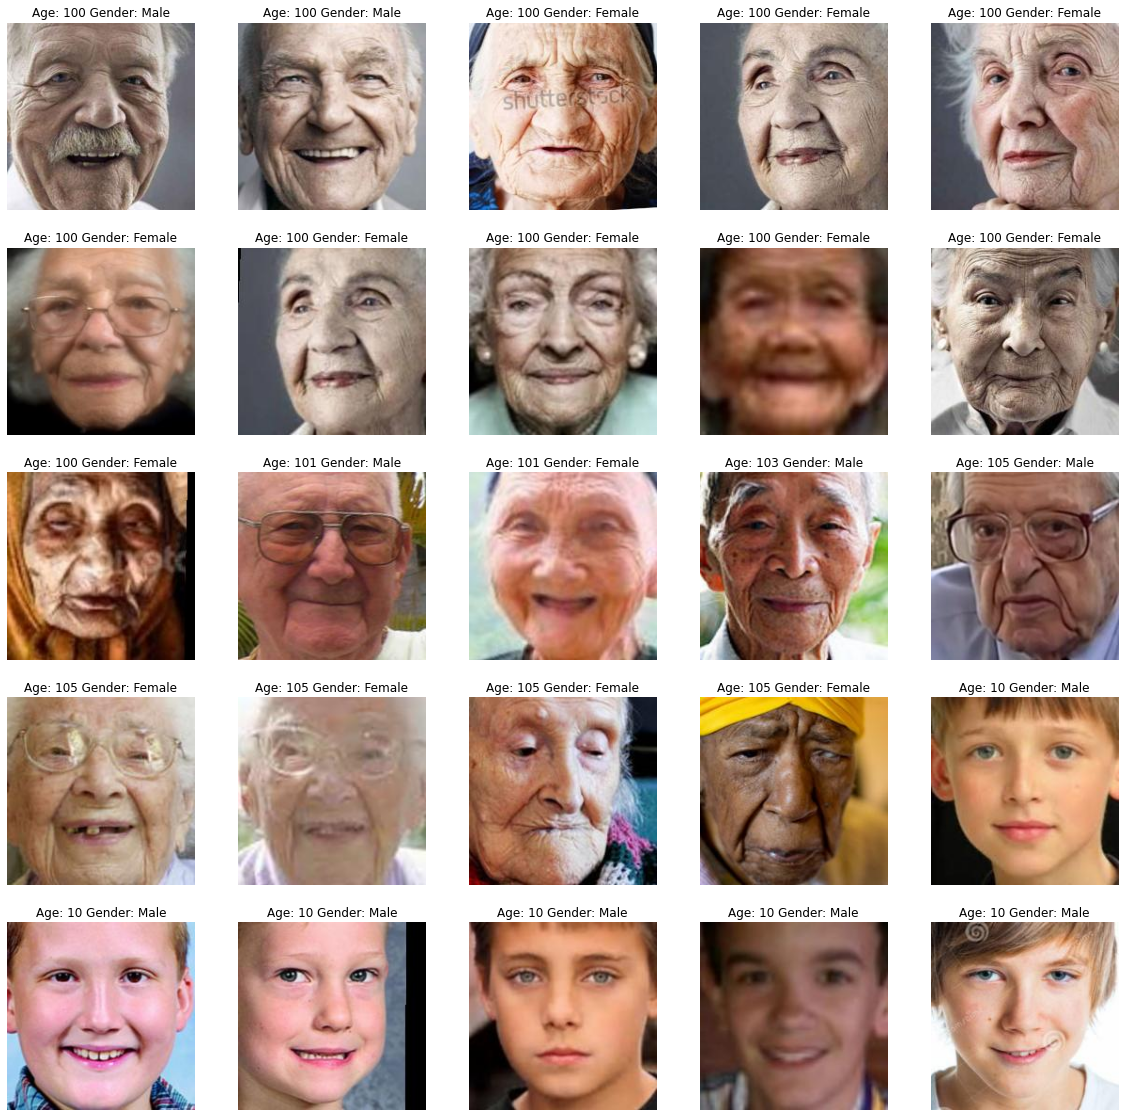

In [9]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [11]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
X.shape

(23708, 128, 128, 1)

In [13]:
# normalize the images
X = X/255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128, 128, 1)

## Model Creation

In [16]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [19]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 330s 551ms/step - loss: 10.8247 - gender_out_loss: 0.6782 - age_out_loss: 10.1465 - gender_out_accuracy: 0.5408 - age_out_accuracy: 0.0591 - val_loss: 34.5238 - val_gender_out_loss: 0.5565 - val_age_out_loss: 33.9672 - val_gender_out_accuracy: 0.7143 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
593/593 [==============================] - 356s 600ms/step - loss: 8.1094 - gender_out_loss: 0.4591 - age_out_loss: 7.6502 - gender_out_accuracy: 0.7816 - age_out_accuracy: 0.0487 - val_loss: 30.1950 - val_gender_out_loss: 0.4885 - val_age_out_loss: 29.7064 - val_gender_out_accuracy: 0.7687 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
593/593 [==============================] - 359s 605ms/step - loss: 7.3129 - gender_out_loss: 0.3800 - age_out_loss: 6.9329 - gender_out_accuracy: 0.8265 - age_out_accuracy: 0.0330 - val_loss: 28.0258 - val_gender_out_loss: 0.4878 - val_age_out_loss: 27.5380 - val_gender_out_accuracy: 0.7777 - val_age_out_accur

In [21]:
model.save_weights('age-gender-model-1/')

In [17]:
model.load_weights('age-gender-model-1/')

## Plot the Results

In [34]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

NameError: name 'history' is not defined

# Prediction with Test Data

  0%|          | 0/1 [00:00<?, ?it/s]

Predicted Gender: Male Predicted Age: 27


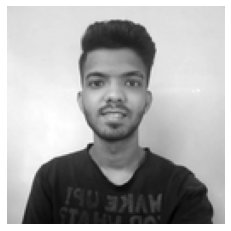

In [36]:
Y = extract_features(['Rushank.jpeg'])
Y.shape
Y = Y/255.0
pred = model.predict(Y[0].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(Y[0].reshape(128, 128), cmap='gray');
